# WS 1.4: Non-Linear Water

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.4. Wed Sep 25, 2024.*

In this notebook we will apply the least-squares method to a non-linear model: [non-linear least-squares estimation](https://mude.citg.tudelft.nl/2024/book/observation_theory/07_NLSQ.html). In this case our model is non-linear in the unknown parameters of interest:

$$
\mathbb{E} ( \begin{bmatrix} Y_1\\ Y_2\\ \vdots\\ Y_m \end{bmatrix}  ) = q(\mathrm{x}) = \begin{bmatrix} q_{1}(\mathrm{x})\\ q_{2}(\mathrm{x})\\ \vdots\\  q_{m}(\mathrm{x}) \end{bmatrix}
$$

In other words, we can no longer use a (linear) A matrix to evaluate the functional model. However, as you have seen in the reading, we still formulate a _linearized_ model in terms of the _difference_ between the initial guess and computed value of each parameter:

$$
\Delta \mathrm{x}_{[0]} = \mathrm{x}- \mathrm{x}_{[0]}
$$

We will apply best linear unbiased estimation to estimate the parameters $\Delta \mathrm{x}_{[0]}$. We will then obtain a new 'estimate' for the unknown parameters $\mathrm{x}_{[1]}=\mathrm{x}_{[0]}+\Delta \mathrm{x}_{[0]}$ and repeat the procedure. This is the Gauss-Newton iteration.

## Background

In this exercise we will consider an aquifer: a subsurface reservoir where water is stored in the pores of a soil or rock formation. If this is unfamiliar to you, think of it as an underground sponge with water in it that responds slowly to change. A well has been installed with monitoring equipment such that a time series of water level in the aquifer has been obtained, and our objective is to create a mathematical model that captures the fluctuations of the water level with time.

Water enters or exits the aquifer due to certain events, such as precipitation, evaporation or groundwater pumping. We assume that the water level in the aquifer is a linear combination of the events, allowing us to write the observation equation as:

$$ L(t) = \sum_{i=1}^{n} h_i(t) + d + \epsilon(t) $$

where $L(t)$ is the observed water level, $h_{i}(t)$ is an event that adds or removes water from the aquifer, $d$ is the base water level of the aquifer and $\epsilon(t)$ is the noise (random error) term. In this exercise we will consider the response due to a single event, $h_k(t)$. Groundwater flows through pores in the aquifer much slower than the application of $h_k(t)$ at time $t_0$. Therefore, the aquifer responds to event $k$ according to a step-response function, $s(t-t_0)$, which has the general form illustrated in the figure below. If the event has a constant value and continues indefinitely after $t_0$ the aquifer will eventually reach a steady-state value $r$ (a scaling factor of $a=1$ is used).

<div>
    <center>
        <img src="./figures/response.png", width=320 />.
    </center>
</div>

For our exercise we will consider a single event, $k$, with a constant input of water, $p$ [m], from time $t_0$ until $t_{\text{end}}$, and zero input before and after. In this case $p$ is assumed to be a deterministic (known) parameter and constant in time (imagine that it represents water inflow to the aquifer due to a rain event). The steady-state aquifer response scales with $p$, resulting in the following step-response function for the aquifer:

$$ 
h_k(t) = p \cdot \underset{s(t-t_0)}{\underbrace{r\left(1-\exp\left(-\frac{t-t_0}{a}\right)\right)}}
$$

where $a$ [days] is a scaling parameter representing the memory of the system (determines how fast the level is rising) and $r$ [m/m] is the response of the aquifier to an input $p$. Once the event stops, the response is described by:

$$ 
h_k(t) = p\cdot r\left(\exp\left(-\frac{t-t_e}{a}\right)-\exp\left(-\frac{t-t_0}{a}\right)\right), \;\; \text{for}\;\; t > t_{\text{end}} 
$$

## Functional model

For this example, we consider a single rainfall event. At $t_0=4$ days, it starts raining, and at $t_{\text{end}}=7$ days it stops raining (and we assume the amount of rainfall to be constant during these days, for the sake of the example...). The observation equations become:

$$
\begin{align}
    \mathbb{E}[L(t_i)] &= d && \text{for} \; t_1\leq t_i < 4\\
    \mathbb{E}[L(t_i)] &= d + p\cdot r\left(1-\exp \left(-\frac{t_i-4}{a} \right) \right) && \text{for} \; 4 \leq t_i \leq 7\\
    \mathbb{E}[L(t_{i})] &= d + p\cdot r\left(\exp \left(-\frac{t_i-7}{a} \right) - \exp \left(-\frac{t_i-4}{a}\right)\right) && \text{for} \; t_i > 7
\end{align}
$$

From these equations, it follows that there are three unknown parameters that need to be estimated: $d$, $r$ and $a$. These equations can be combined into a single equation by making use of the <a href="https://en.wikipedia.org/wiki/Heaviside_step_function"> Heaviside function</a> $H(\Delta t)$:

$$\mathbb{E}\left[L(t_i)\right] = d + H(t_i-t_{0}) \cdot p\cdot r \left(1-\exp\left(-\frac{t_i-t_0}{a}\right)\right) - H(t_i-t_{\text{end}}) \cdot p\cdot r \left(1-\exp\left(-\frac{t_i-t_{\text{end}}}{a}\right)\right)$$

with $H(\Delta t) = 1$ if $\Delta t \geq 0$ and $H(\Delta t) = 0$ otherwise. <b>Check yourself that this gives indeed the same observation equations as above.</b>

The functional model can be defined as follows, using <a href="https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html"> NumPy's heaviside</a> function:           

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats.distributions import chi2

plt.rcParams.update({'font.size': 14})

## Part 0: Set Up and Understand Functions

As described at the top of the notebook, our functional model is no longer a linear system of equations. This means we can no longer use a simple A matrix to evaluate it. Instead, we will use a Python function. Recall that the general form of the functional model is $\mathrm{Y}=q(\mathrm{x}) + \epsilon$, where $\mathrm{x}$ represents the vector of model parameters. Note also that to implement this model in practice often additional (deterministic!) parameters are required. This can be written in a Python function with the following form of input arguments:

```
y_comp = compute_y(x, <auxiliary_arguments>)
```

Where the name `compute_y()` is used to indicate that this is not the functional model, as the Python function does not include the random errors. The <auxiliary_arguments>` will be different in type and/or number on a case-by-case basis. Your code will generally be more compact and adaptable to other cases if the parameters are specified in a list, array or tuple. 

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.1:</b>   

Read the code below to understand the functional model. Be sure to understand which objects are the parameters of interest, and what the auxiliary arguments are (type and number).
</p>
</div>

In [2]:
def compute_y(x, times, rain):
    '''Functional model, q: response due to rain event.
    
    Inputs:
      x: tuple, list or array of parameters (d, a, r)
      times: array of times
      rain: tuple, list or array describing rain event
             (rain (m), start day, stop day)

    Returns: ndarray of groundwater levels due to rain event
    '''
    h = (x[0]
         + (np.heaviside(times - rain[1], 1)
            *rain[0]*x[2]*(1 - np.exp(-(times - rain[1])/x[1]))
            - np.heaviside(times - rain[2], 1)
              *rain[0]*x[2]*(1 - np.exp(-(times - rain[2])/x[1]))
            )
         )
    return h

### Apply the Functional Model

If we generate a vector of time steps, we can plot the (exact) response of a system with parameters using the ```rain_event``` function defined above.

The known input is: $p=0.05$ m.

Choose your own values for $d$, $a$, and $r$.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.2:</b>   

Familiarize yourself with the model by assigning values to the unknown parameters below. Continue changing values and re-running the cell until you are comfortable with the effect that each parameter has on the model. Note that the scale of the water level response to 0.05 m water input (e.g., precipiation) should be meters (i.e., >0 m and <10 m).

<em>Hint: if you are having trouble visualizing the model, adjust the y-axis limits using <code>plt.ylim([ , ]</code>)
</p>
</div>

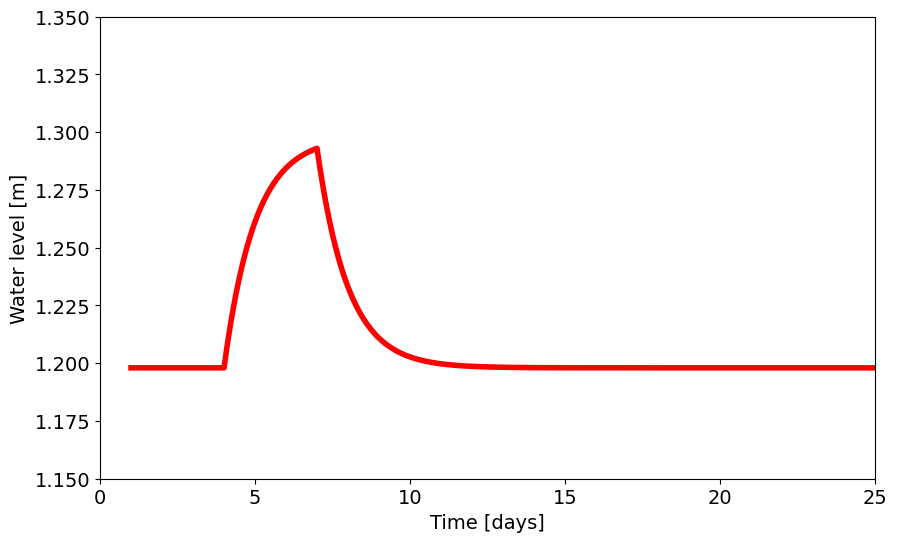

In [3]:
d = 1.198
a = 1
r = 2

test_n_days = 25
test_times = np.arange(1, test_n_days+1, 0.1)
test_h_t = compute_y((d, a, r), test_times, (0.05, 4, 7))
plt.figure(figsize=(10, 6))
plt.plot(test_times, test_h_t,'r-', linewidth=4.0)
plt.xlabel('Time [days]')
plt.ylabel('Water level [m]')
plt.xlim([0, test_n_days])
plt.ylim([1.15, 1.35]);

## Reading in the observations

We collected observations of the water level in the aquifer for 25 consecutive days and are stored ```data``` folder. Observations start at $t=1$.

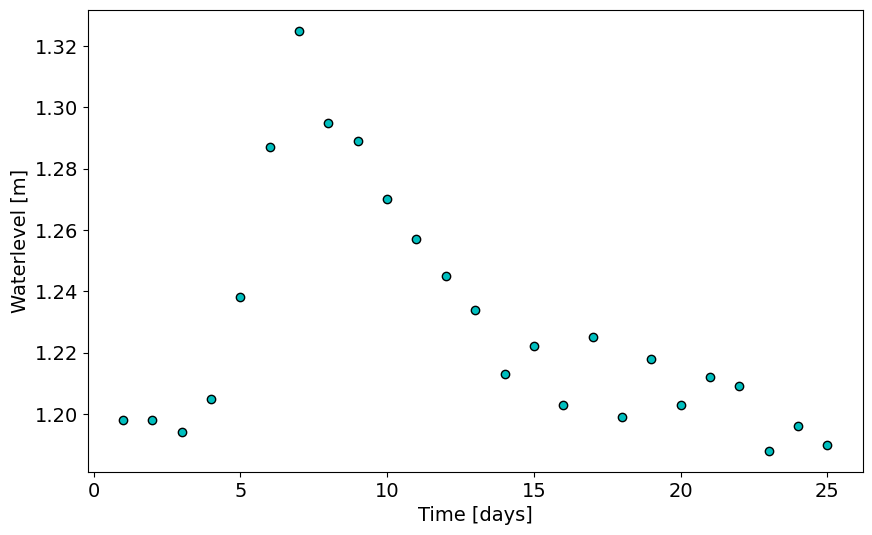

In [4]:
n_days = 25
y = np.genfromtxt('./data/well_levels.csv' , delimiter=" ,")
times = np.arange(1, n_days+1, 1)

plt.figure(figsize=(10, 6))
plt.plot(times, y,'co', mec='black')
plt.xlabel('Time [days]')
plt.ylabel('Waterlevel [m]');

## Estimating the parameters using Gauss-Newton iteration

Using only the data of the observations we want to find the values for $d$, $a$ and $r$. This can be done with Gauss-Newton iteration. 

The Gauss-Newton iteration works with several steps:

Start with initial guess $\mathrm{x}_{[0]}$, and start iteration with $i=0$
1. Calculate observed-minus-computed $\Delta \mathrm{y}_{[i]} = \mathrm{y} - q(\mathrm{x}_{[i]}) $
2. Determine the Jacobian $\mathrm{J}_{[i]}$
3. Estimate $\Delta \hat{\mathrm{x}}_{[i]}=\left(\mathrm{J}_{[i]}^T \Sigma_{Y}^{-1} \mathrm{J}_{[i]} \right)^{-1}\mathrm{J}_{[i]}^T \Sigma_{Y}^{-1}\Delta \mathrm{y}_{[i]}$
4. New guess $\mathrm{x}_{[i+1]}=\Delta\hat{\mathrm{x}}_{[i]}+ \mathrm{x}_{[i]}$
5. If stop criterion is met: set $\hat{\mathrm{x}}=\mathrm{x}_{[i+1]}$  and break, otherwise set $i:=i+1$ and go to step 1

Our stop criterion is:

$$
\Delta \hat{\mathrm{x}}_{[i]}^T \mathrm{N}_{[i]} \Delta \hat{\mathrm{x}}_{[i]} < \delta \;\; \text{with} \;\;\mathrm{N}_{[i]}=\mathrm{J}_{[i]}^T \Sigma_{Y}^{-1} \mathrm{J}_{[i]}
$$

## Computing the partial derivatives for the Jacobian matrix


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>   

Derive the partial derivatives that you will need for the Jacobian (on paper), then write them in the code below.

<em>Hints: when implementing the partial derivatives consider the dimensions of the Jacobian matrix carefully (the first term should <b>not</b> be 1; think "vector"). Also, the heaviside function takes care of the piece-wise function, so you do not need to implement this "manually."</em>
</p>
</div>

In [5]:
def jacobian(x, times, rain):
    '''Compute Jacobian of the functional model.
    
    Input:
      x: tuple, list or array of parameters (d, a, r)
      times: array of times
      rain: tuple, list or array describing rain event
             (rain (m), start day, stop day)

    Outputs: The Jacobian
             (partial derivatives w.r.t. d, a, and r)
    '''

    dqdd = 1
    dqda = (np.heaviside(times - rain[1], 1)
            *rain[0]*x[2]*(-np.exp(-(times - rain[1])/x[1])*(times - rain[1])/(x[1]**2))
            - np.heaviside(times - rain[2], 1)
              *rain[0]*x[2]*(-np.exp(-(times - rain[2])/x[1])*(times - rain[2])/(x[1]**2))
            )
    dqdr = (np.heaviside(times - rain[1], 1)
            *rain[0]*(1 - np.exp(-(times - rain[1])/x[1]))
            - np.heaviside(times - rain[2], 1)
              *rain[0]*(1 - np.exp(-(times - rain[2])/x[1]))
            )
    J = np.column_stack((np.ones(len(times))*dqdd,dqda,dqdr))
    return J

## Running the Gauss-Newton iteration

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\textbf{Task 2}$  
    
In the code you will first need to choose the initial values <code>d_init, a_init, r_init</code>. Hint: for the choice of <code>d_init</code> = $d_{[0]}$ have a look at the plot with the observations (remember it is the base level of the aquifer before the rain starts). Using the intuition you gained from the plot from the functional model (Task 0), find appropriate initial values for $a$ and $r$ by comparing the graph you get with the observations.

Next we will set the stochastic model, and initialize some other variables needed for the <code>while</code>-loop, where the actual Gauss-Newton iteration takes place. Try to see if you can follow the steps above, and fill in the missing code, where you have to compute 

- the observed-minus-computed observations <code>Delta_y_i</code> $=\Delta y_{[i]}$,
- the estimate <code>Delta_x_hat_i</code>$=\Delta\hat{\mathrm{x}}_{[i]}$,
- <code>x_norm</code>$=\Delta \hat{\mathrm{x}}_{[i]}^T \mathrm{N}_{[i]} \Delta \hat{\mathrm{x}}_{[i]}$

Note in particular the 2 stop criteria used for the while loop. You should reach a solution within 50 iterations, otherwise you should reconsider the initial values.
    </p>
</div>

In [6]:
d_init = 1.2
a_init = 3
r_init = 4

rain_event = (0.05, 4, 7)

sigma = 0.01
var_Y = sigma**2
inv_Sigma_Y = 1/var_Y * np.eye(len(y))

max_iter = 50
x_norm = 10000  # initialize stop criteria (norm of x)

# x_hat_i: array to store the estimated parameters at each iteration
param_init = np.array([d_init, a_init, r_init])
x_hat_i = np.zeros((3, max_iter))
x_hat_i[:] = np.nan
x_hat_i[:, 0] = param_init

iteration = 0

while x_norm >= 1e-12 and iteration < max_iter - 1:

    y_comp_i = compute_y(x_hat_i[:, iteration], times, rain_event)
    
    Delta_y = y - y_comp_i
    
    J_i = jacobian(x_hat_i[:, iteration], times, rain_event)
    N_i = J_i.T @ inv_Sigma_Y @ J_i
    
    Delta_x_hat_i = inv(N_i) @ J_i.T @ inv_Sigma_Y @ Delta_y

    x_hat_i[:, iteration+1] = x_hat_i[:, iteration] + Delta_x_hat_i

    x_norm = Delta_x_hat_i.T @ N_i @ Delta_x_hat_i

    iteration += 1

    if iteration == max_iter - 1:
        print("Number of iterations too large, check initial values.")

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3:</b>  
    
If the process in the previous task worked well, you should be able to complete the print statements below to help summarize your results.
    </p>
</div>

In [8]:
print('Initial estimates:')
print(f'base level [m]:\t\t {round(d_init, 4)}')
print(f'scaling parameter:\t {round(a_init, 4)}')
print(f'response [m/m]:\t\t {round(r_init, 4)}','\n')

print('Final estimates:')
print(f'base level [m]:\t\t {round(x_hat_i[0,iteration], 4)}')
print(f'scaling parameter:\t {round(x_hat_i[1,iteration], 4)}')
print(f'response [m/m]:\t\t {round(x_hat_i[2,iteration], 4)}')

print(f'\nNumber of unknowns:\t {len(x_hat_i)}')
print(f'Number of observations:\t {len(y)}')
print(f'Redundancy:\t\t {len(y)-len(x_hat_i)}')

Initial estimates:
base level [m]:		 1.2
scaling parameter:	 3
response [m/m]:		 4 

Final estimates:
base level [m]:		 1.1948
scaling parameter:	 5.0616
response [m/m]:		 5.735

Number of unknowns:	 3
Number of observations:	 25
Redundancy:		 22


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4:</b>  
    
Complete the code below to generate a plot to visualize the model and the data.
    </p>
</div>

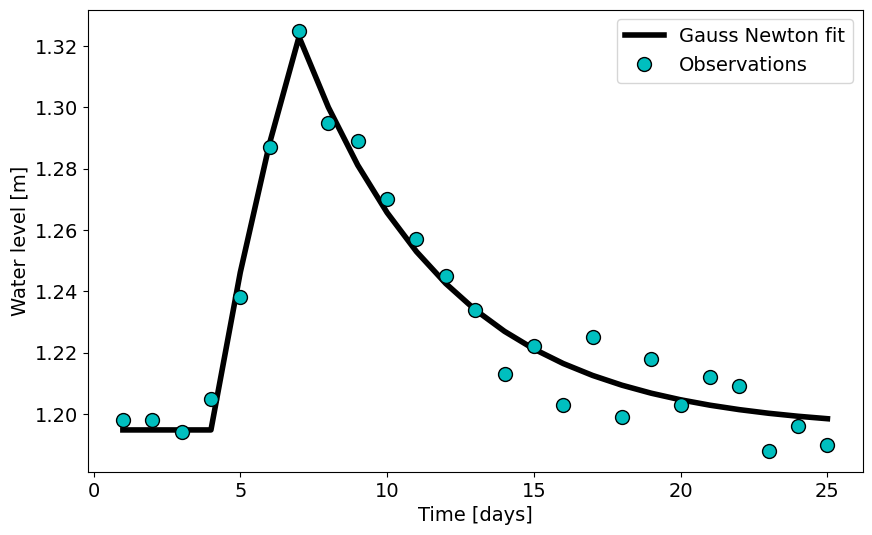

In [11]:
y_hat = (x_hat_i[0,iteration]
         + (np.heaviside(times - rain_event[1], 1)
            *rain_event[0]*x_hat_i[2,iteration]*(1 - np.exp(-(times - rain_event[1])/x_hat_i[1,iteration]))
            - np.heaviside(times - rain_event[2], 1)
              *rain_event[0]*x_hat_i[2,iteration]*(1 - np.exp(-(times - rain_event[2])/x_hat_i[1,iteration]))
            )
         )

plt.figure(figsize=(10, 6))
t = np.arange(1, n_days+1, 0.1)
plt.plot(times, y_hat , linewidth=4,
         label='Gauss Newton fit', color='black')
plt.plot(times, y, 'co', mec='black',
         markersize=10, label='Observations')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Water level [m]');

## Visualization

### Estimates vs. iteration number

Now we will consider how the estimate of the model parameter changes during the Gauss-Newton iteration.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>  
    
Run the cell below, then comment on the convergence of each parameter, as well as the model overall (just one or two sentences).
    </p>
</div>

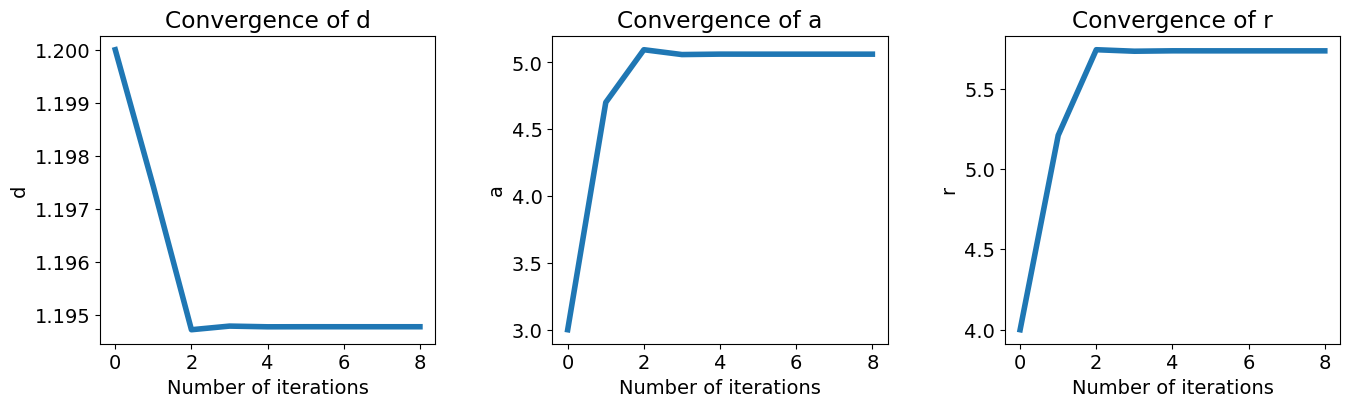

In [12]:
params = ['d', 'a', 'r']
fig, ax = plt.subplots(1,3, figsize=(16,4))
plt.subplots_adjust(wspace=0.35)
for i in range(3):
    ax[i].plot(x_hat_i[i, :].T, linewidth=4)
    ax[i].set_title(f'Convergence of {params[i]}')
    ax[i].set_xlabel(f'Number of iterations')
    ax[i].set_ylabel(f'{params[i]}')

**Write your answer in this Markdown cell.**

## Overall model test

Looking at the final results, it seems the model provides a good fit to the data. Let's test it with a probability of false alarm of 0.05.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6:</b>  
    
Fill in the missing code below to set the degrees of freedom. Include also the appropriate <code>if</code> statement criteria.
    </p>
</div>

In [13]:
e_hat = y - y_hat
Tq = e_hat.T @ inv_Sigma_Y @ e_hat

alpha = 0.05

q = len(y)-len(x_hat_i)

k = chi2.ppf(1 - alpha, q)

if Tq < k:
    print(f"(T = {Tq:.1f}) < (K = {k:.1f}), OMT is accepted.")
else:
    print(f"(T = {Tq:.1f}) > (K = {k:.1f}), OMT is rejected.")

(T = 14.7) < (K = 33.9), OMT is accepted.


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8:</b>  
    
Play with the value of <code>alpha</code> and see how it changes the critical value <code>k</code>. Why does it become smaller/larger? What is the impact on the probability of rejecting the null hypothesis?
    </p>
</div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2024 <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0 License</a>.